In [1]:
import numpy as np
# 2d Eular Equation solver for oblique shock wave

# Parameters initialization
nmax = 20  # Number of grid points in y-direction
mmax = 40  # Number of grid points in x-direction
tmax = 200  # Number of time steps

# grid initialization
bigx = np.zeros((nmax+1, mmax+1)) # x-coordinate of grid points
bigy = np.zeros((nmax+1, mmax+1)) # y-coordinate of grid points
gridres = 2 * mmax // 40            # grid resolution
IS = 5 * gridres                    # shock position
H = 2.4                             # height of the channel
L = 4.0                             # length of the channel
theta = 15.0                # angle of the oblique line  

dx = L / (mmax)             # grid spacing in x-direction

dy = np.zeros(mmax+1)             

dh = np.tan(theta * np.pi / 180.0) * dx     # height change of the grid
dy[:IS] = H / (nmax)                    # grid spacing in y-direction
for i in range(IS, mmax+1):
    dy[i] = (H - dh * (i - IS)) / (nmax)

for j in range(mmax+1):
    bigx[:, j] = j * dx
    for i in range(nmax+1):
        bigy[i, j] = dy[j] * i
        if j >= IS:
            bigy[i, j] +=  (j - IS) * dh # oblique line
            
grid = np.zeros((nmax+1, mmax+1, 3)) # grid points

# save the grid points and judge whether the grid point is on the boundary
for i in range(nmax+1):
    for j in range(mmax+1):
        grid[i,j,0] = bigx[i,j]
        grid[i,j,1] = bigy[i,j]
        if i == 0 or i == nmax or j == 0 or j == mmax:
            grid[i,j,2] = 1
        else:
            grid[i,j,2] = 0

# transformation grid from physical domain to computational domain
# eta = x
# xi = y/H if j < IS else (y - dh * (j - IS))/(H - dh * (j - IS))

eta = np.zeros((nmax+1, mmax+1))
xi = np.zeros((nmax+1, mmax+1))
transformed_grid = np.zeros((nmax+1, mmax+1, 3))

for i in range(nmax+1):
    for j in range(mmax+1):
        eta[i,j] = bigx[i,j]
        if j < IS:
            xi[i,j] = bigy[i,j]/H
        else:
            xi[i,j] = (bigy[i,j]-dh*(j-IS))/(H-dh*(j-IS))
        transformed_grid[i,j,0] = eta[i,j]
        transformed_grid[i,j,1] = xi[i,j]
        transformed_grid[i,j,2] = grid[i,j,2]



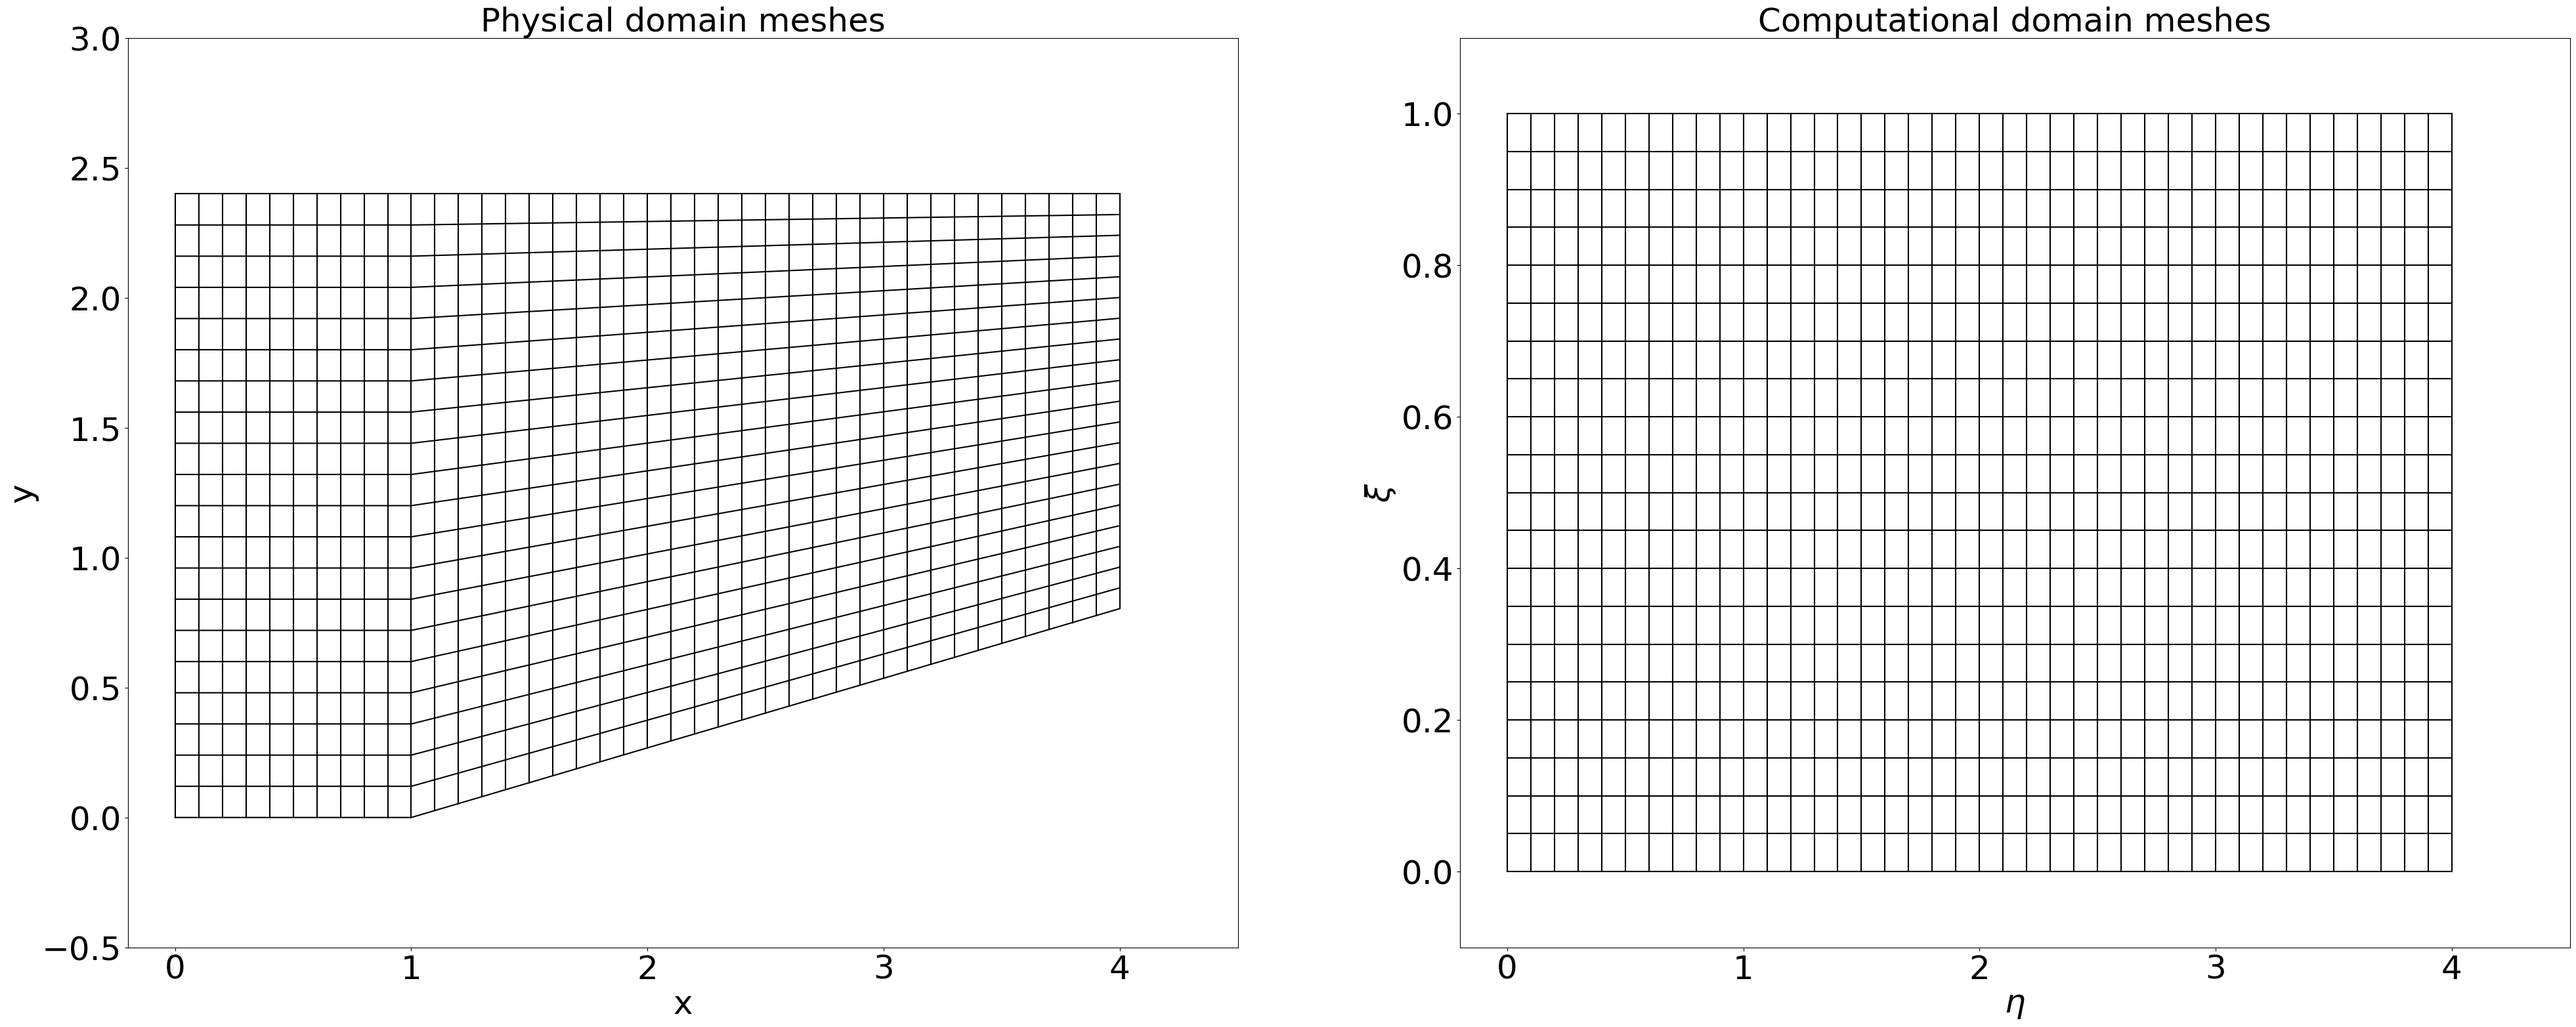

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm

# virsualize
fig, axs = plt.subplots(1, 2, figsize=(48, 18))
for i in range(nmax+1):
    axs[0].plot(bigx[i, :], bigy[i, :], 'k')
    axs[1].plot(eta[i, :], xi[i, :], 'k')
for j in range(mmax+1):
    axs[0].plot(bigx[:, j], bigy[:, j], 'k')
    axs[1].plot(eta[:, j], xi[:, j], 'k')

axs[0].set_title("Physical domain meshes", fontsize=36)
axs[0].set_xlabel("x", fontsize=36)
axs[0].set_ylabel("y", fontsize=36)
# plt.legend(loc='best', fontsize=24, frameon=False)
axs[0].set_xlim(-0.2, 4.5)
axs[0].set_ylim(-0.5, 3)

axs[1].set_title("Computational domain meshes", fontsize=36)
axs[1].set_xlabel(r"$\eta$", fontsize=36)
axs[1].set_ylabel(r"$\xi$", fontsize=36)
# plt.legend(loc='best', fontsize=24, frameon=False)
axs[1].set_xlim(-0.2, 4.5)
axs[1].set_ylim(-0.1, 1.1)

for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=36)
    ax.tick_params(axis='both', which='minor', labelsize=36)

plt.show()

In [3]:
# parameters initialization
dis = 0.85                              # artificial dissipation coefficient
dymin = bigy[1,mmax-1] - bigy[0,mmax-1] # minimum grid spacing in y-direction
p1 = 99719                              # pressure at the inlet
R = 287.14                              # gas constant
T = 293.15                              # temperature
rho1 = p1/(R*T)                        # density at the inlet
# M1 = 2.9
gamma = 1.4                             # ratio of specific heats
c1 = np.sqrt(gamma*p1/rho1)             # speed of sound at the inlet
u1 = 686.47                             # velocity u at the inlet     
v1 = 0                                  # velocity v at the inlet    
e1 = rho1*(u1*u1 + v1*v1)/2 + p1/(gamma-1) # total energy at the inlet

# variables initialization
U = np.zeros((4,nmax+1,mmax+1))
F = np.zeros((4,nmax+1,mmax+1))
E = np.zeros((4,nmax+1,mmax+1))

newU = np.zeros((4,nmax+1,mmax+1))
newU2 = np.zeros((4,nmax+1,mmax+1))

rho = np.zeros((nmax+1,mmax+1))
u = np.zeros((nmax+1,mmax+1))
v = np.zeros((nmax+1,mmax+1))
p = np.zeros((nmax+1,mmax+1))
e = np.zeros((nmax+1,mmax+1))
c = np.zeros((nmax+1,mmax+1))

mindt = 0


Edot = np.zeros((4,nmax+1,mmax+1))
Epdot = np.zeros((4,nmax+1,mmax+1))
Emdot = np.zeros((4,nmax+1,mmax+1))
Fdot = np.zeros((4,nmax+1,mmax+1))
Fpdot = np.zeros((4,nmax+1,mmax+1))
Fmdot = np.zeros((4,nmax+1,mmax+1))

# save residual
max_residuals = []  
l2_residuals = []


In [4]:
# calucate the angle of shock wave
# f(beta) = tan(theta) - 2*cot(beta)*[(M1^2*sin^2(beta)-1)/(M1^2*(gamma+cos(2*beta))+2)]

M1 = u1/c1
beta = 15*np.pi/180

def f(beta):
    return np.tan(theta*np.pi/180) - 2*(1/np.tan(beta))*((M1**2*np.sin(beta)**2-1)/(M1**2*(gamma+np.cos(2*beta))+2))

def df(beta):
    h = 1e-6
    return (f(beta+h)-f(beta-h))/(2*h)

learn_rate = 0.01
StopIteration = 1e-6

while abs(f(beta)) > StopIteration:
    beta = beta - learn_rate*f(beta)/df(beta)
    print(beta)

# 可视化激波
# y = tan(beta)*x
# beta = -beta if meet the boundary
wave_x = bigx[0,IS:mmax+1]
tmp = 0
wave_y = []
for i in range(IS,mmax+1):
    if tmp > max(bigy[:,i]) or tmp < min(bigy[:,i]):
        beta = -beta
    wave_y.append(tmp)
    tmp = np.tan(beta)*dx+tmp

# y = (x-dh*(j-IS))/(H-dh*(j-IS))
transformed_wave_y = []
for i in range(IS,mmax+1):
    transformed_wave_y.append((wave_y[i-IS]-dh*(i-IS))/(H-dh*(i-IS)))

0.26422090865253756
0.2666538710798039
0.2690980339683677
0.27155315067503794
0.2740189691638559
0.27649523215006955
0.27898167725296064
0.28147803715405273
0.283984039763556
0.28649940839240085
0.2890238619307579
0.2915571150325997
0.29409887830566195
0.2966488585068112
0.2992067587419113
0.30177227867065715
0.304345114715331
0.30692496027344557
0.30951150593361965
0.31210443969435114
0.3147034471854118
0.3173082118915306
0.31991841537753973
0.32253373751461706
0.32515385670815056
0.3277784501251277
0.33040719392232903
0.3330397634735805
0.3356758335965516
0.3383150787784457
0.3409571733999796
0.3436017919569035
0.34624860928068096
0.3488973007545617
0.35154754252822923
0.35419901172836576
0.35685138666570315
0.3595043470383866
0.36215757413015015
0.3648107510053009
0.36746356269822694
0.37011569639750724
0.37276684162575136
0.37541669041339915
0.3780649374669019
0.38071128033171536
0.3833554195485646
0.38599705880423457
0.38863590507592843
0.39127166877015324
0.39390406385390864
0.39

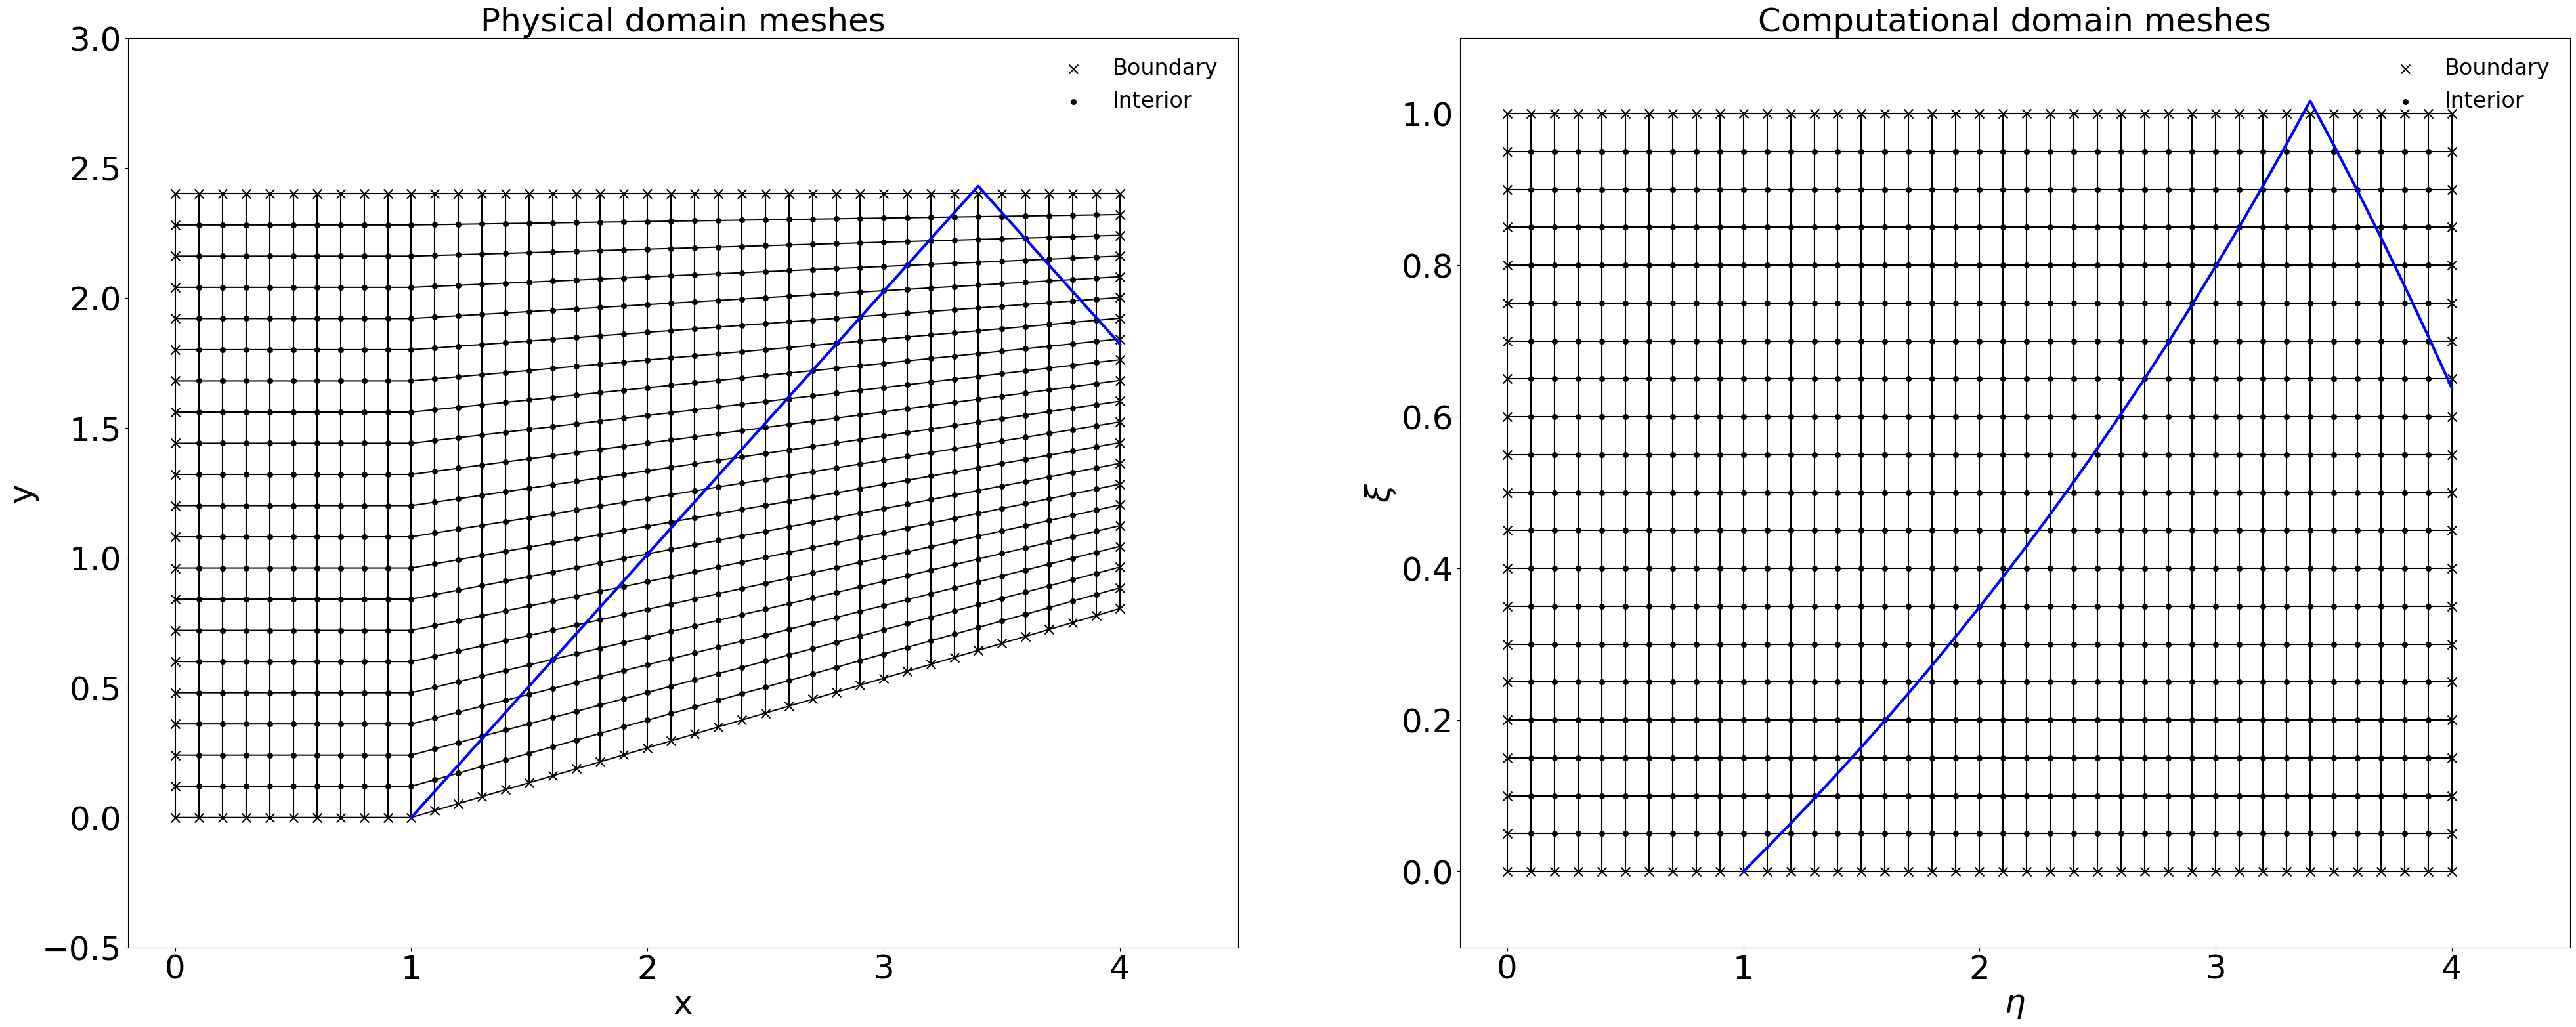

In [5]:
# 绘制网格可视化
import matplotlib.pyplot as plt
from matplotlib import cm

# 可视化网格
fig, axs = plt.subplots(1, 2, figsize=(48, 18))
for i in range(nmax+1):
    axs[0].plot(bigx[i,:],bigy[i,:],'k')
    axs[1].plot(transformed_grid[i,:,0],transformed_grid[i,:,1],'k')
for j in range(mmax+1):
    axs[0].plot(bigx[:,j],bigy[:,j],'k')
    axs[1].plot(transformed_grid[:,j,0],transformed_grid[:,j,1],'k')

# 初始化标志变量
boundary_label_added = False
interior_label_added = False

size_change = (mmax//40)**2

# 可视化格心
if mmax<100:
    for i in range(nmax+1):
        for j in range(mmax+1):
            if grid[i, j, 2] == 1:
                if not boundary_label_added:
                    axs[0].scatter(grid[i, j, 0], grid[i, j, 1], marker='x', c='black', s=100/size_change, label='Boundary')
                    axs[1].scatter(transformed_grid[i, j, 0], transformed_grid[i, j, 1], marker='x', c='black', s=100/size_change, label='Boundary')
                    boundary_label_added = True
                else:
                    axs[0].scatter(grid[i, j, 0], grid[i, j, 1], marker='x', c='black', s=100/size_change)
                    axs[1].scatter(transformed_grid[i, j, 0], transformed_grid[i, j, 1], marker='x', c='black', s=100/size_change)
            else:
                if not interior_label_added:
                    axs[0].scatter(grid[i, j, 0], grid[i, j, 1], marker='o', c='black', s=30/size_change, label='Interior')
                    axs[1].scatter(transformed_grid[i, j, 0], transformed_grid[i, j, 1], marker='o', c='black', s=30/size_change, label='Interior')
                    interior_label_added = True
                else:
                    axs[0].scatter(grid[i, j, 0], grid[i, j, 1], marker='o', c='black', s=30/size_change)
                    axs[1].scatter(transformed_grid[i, j, 0], transformed_grid[i, j, 1], marker='o', c='black', s=30/size_change)       

axs[0].plot(wave_x,wave_y,'blue',linewidth=3)

axs[0].set_title("Physical domain meshes", fontsize=36)
axs[0].set_xlabel("x", fontsize=36)
axs[0].set_ylabel("y", fontsize=36)
axs[0].legend(loc='best', fontsize=24, frameon=False)
axs[0].set_xlim(-0.2, 4.5)
axs[0].set_ylim(-0.5, 3)

axs[1].plot(wave_x,transformed_wave_y,'blue',linewidth=3)

axs[1].set_title("Computational domain meshes", fontsize=36)
axs[1].set_xlabel(r"$\eta$", fontsize=36)
axs[1].set_ylabel(r"$\xi$", fontsize=36)
axs[1].legend(loc='best', fontsize=24, frameon=False)
axs[1].set_xlim(-0.2, 4.5)
axs[1].set_ylim(-0.1, 1.1)

for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=36)
    ax.tick_params(axis='both', which='minor', labelsize=36)

plt.show()


In [6]:
U[0,:,:] = rho1
U[1,:,:] = rho1*u1
U[2,:,:] = rho1*v1
U[3,:,:] = e1
E[0,:,:] = rho1*u1
E[1,:,:] = rho1*u1*u1 + p1
E[2,:,:] = rho1*u1*v1
E[3,:,:] = (e1 + p1)*u1
F[0,:,:] = rho1*v1
F[1,:,:] = rho1*u1*v1
F[2,:,:] = rho1*v1*v1 + p1
F[3,:,:] = (e1 + p1)*v1


newU2 = U.copy()
newU = U.copy()